<a id="topD"></a>

# Splitting COS Exposures into sub-exposures with `splittag`

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Filtering Cosmic Origins Spectrograph (COS) `TIME-TAG` data using the splittag tool**
   #### 1. [**Examining the data to determine how to split the files**](#exSp)
<!--    ##### - 1.1. [The Classic HST Web Search](#mastD)
   ##### - 1.2. [Searching for a Series of Observations on the Classic Web Search](#WebSearchSeriesD)
   ##### - 1.3. [The New MAST Portal](#mastportD)
   ##### - 1.4. [Searching for a Series of Observations on the New MAST Portal](#mastportSeriesD) -->
   #### 2. [**Using `splittag` to create multiple sub-exposure files**](#SpSp)
<!--    ##### - 2.1. [Searching for a single source with Astroquery](#Astroquery1D)
   ##### - 2.2. [Narrowing Search with Observational Parameters](#NarrowSearchD)
   ##### - 2.3. [Choosing and Downloading Data Products](#dataprodsD)
   ##### - 2.4. [Using astroquery to find data on a series of sources](#Astroquery2D)
 -->
   #### 3. [**Extracting spectra from the sub-exposures using `CalCOS`**](#extractSp)


# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through filtering `TIME-TAG` datapoints obtained by COS based on arbitrary times.

COS Data can be taken in [`TIME-TAG`](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design) mode, in which each individual encounter with a photon is recorded with its own metadata such as the time of the encounter. You may wish to split a COS exposure into multiple subexposure files. For instance, a transit may occur during your exposure, and you may wish to see the difference between the source's spectrum before, during, and after the transit. This is possible with `TIME-TAG` data, and the functionality to do this is built into the [`COSTools` python module](https://github.com/spacetelescope/costools) with the tool `splittag`. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `costools splittag` to select `TIME-TAG` datapoints by their time of encounter
- `calcos` to re-process the data
- `numpy` to handle array functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `glob` and `os` for working with system files
- `matplotlib.pyplot` and `gridspec` for plotting data
- `astroquery.mast Mast` and `Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `warnings` and `astropy.units Warnings` for supressing a warning that is not helpful later on.

These python packages, including `calcos` and `costools` are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

In [1]:
conda activate astroconda_plhst_20210505_2


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [1]:
# for filtering time-tag events by time
from costools import splittag
# for processing cos data
import calcos 
# for array manipulation
import numpy as np
# for reading fits files
from astropy.io import fits                                            
from astropy.table import Table
# for system files
import glob
import os
# for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
# for downloading the data
from astroquery.mast import Observations as Obs
# For supressing an unhelpful warning:
import warnings
from astropy.units import UnitsWarning

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


# Delete this and following cell!!!

In [2]:
!rm -r ./output/*
del os.environ['lref']
#### DELETE THIS CELL IN FINAL!!!!

## We will also define a few directories we will need:

In [3]:
output_dir = './output/'
plots_dir = output_dir + 'plots/'
# Make the directories in case they don't exist
!mkdir -p ./output 
!mkdir -p ./output/plots/

## And we will need to download the data we wish to filter and analyze
We choose the exposure with obs_id: `lc1va0010`, because we happen to know it contains an exposure taken while the target, [IY UMa](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=IY+UMa), underwent a transit event. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).

In [4]:
# Find all MAST data on this obs id:
pl = Obs.get_product_list(Obs.query_criteria(obs_id = 'lc1va0010'))
# Filter and download the Corrtag TIME-TAG files:
plf = Obs.filter_products(pl, productSubGroupDescription =  ('CORRTAG_A','CORRTAG_B'))
downloaded_corrtags = Obs.download_products(plf)['Local Path']
# Filter and download the extracted spectra (X1D) files:
plf = Obs.filter_products(pl, productSubGroupDescription = ('X1D'))
downloaded_x1ds = Obs.download_products(plf)['Local Path']

# Let us know how many corrtags were found:
print(f"#####\nFound {len(downloaded_corrtags)} corrtag exposure files")

INFO: Found cached file ./mastDownload/HST/lc1va0yeq/lc1va0yeq_corrtag_a.fits with expected size 5564160. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yjq/lc1va0yjq_corrtag_a.fits with expected size 4129920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zcq/lc1va0zcq_corrtag_a.fits with expected size 14788800. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zgq/lc1va0zgq_corrtag_a.fits with expected size 8593920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yeq/lc1va0yeq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0yjq/lc1va0yjq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zcq/lc1va0zcq_x1d.fits with expected size 1716480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/lc1va0zgq/lc1va0zgq_x1d.fits with expected size 1716480. [astroquery.query]
#####
Found 4 corrtag e

<a id= exSp></a>
# 1. Examining the data to determine how to split the files
We chose this dataset because of its transit event. However, let's suppose for a moment that we don't know which, if any, of our exposures have transits or other time-variable events. We'll imagine we are simply investigating our data.

##### To look for transits and other anomalies, we will create and examine a rough lightcurve of our four exposures. 
A lightcurve is simply a graph of net light or photon counts over time. We can make one by grabbing the time of all recorded photon events from each exposure, and plotting a histogram of the times. There are packages which can create detailed lightcurves, such as [lightcurve](https://github.com/justincely/lightcurve), but we will make these simple lightcurve plots ourselves.

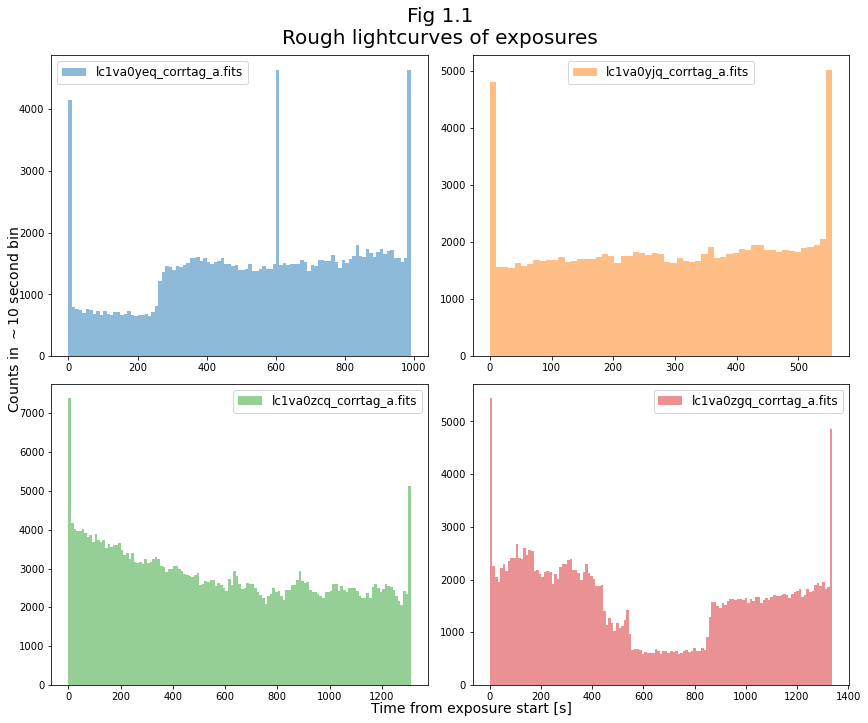

In [5]:
# Build the figure structure
fig = plt.figure(figsize = (12, 10))
gs = fig.add_gridspec(nrows = 2, ncols = 2) # Using gridspec to let us control panel sizes and locations
# Get the time data for each exposure
binsize = 10 # Number of seconds in a bin
for i, ctag in enumerate(downloaded_corrtags):
    ax = fig.add_subplot(gs[int(i/2),i%2]) # make the subplot
    ctab = Table.read(ctag,1) # read the data
    timesc = ctab['TIME']
    # plot the histogram of times
    a,b,c = ax.hist(timesc,bins = int(max(timesc)/binsize), alpha = 0.5, label = os.path.basename(ctag),
                   color = 'C0C1C2C3'[2*i:2*i+2])
    plt.legend(fontsize = 12)
# Format the Figure
plt.suptitle("Fig 1.1\nRough lightcurves of exposures", fontsize = 20)
fig.text(x = 0.42, y = -0.0001, s = "Time from exposure start [s]", 
        fontsize = 14)
fig.text(y = 0.42, x = -0.001, rotation = 'vertical', s = f"Counts in $\sim${binsize} second bin", 
        fontsize = 14)
plt.tight_layout()
plt.savefig(plots_dir + 'compare_exposures.png', bbox_inches = 'tight', dpi = 200)

We can see an apparent transit in the exposure `lc1va0zgq`, ocurring from about 450 - 850 seconds into the exposure. We highlight this in figure 1.2 below.

Exposure `lc1va0yeq` also seems to contain at least the latter part of a transit, but for now we'll focus on `lc1va0zgq`.

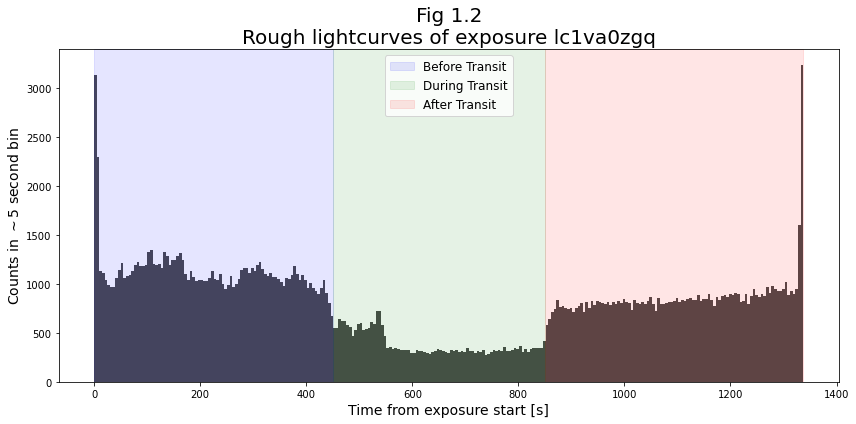

In [6]:
# Find the path to the right exposure
transit_exp = [exp for exp in downloaded_corrtags if "zgq" in exp][0]
transit_basename = os.path.basename(transit_exp).split('_')[0]

# Create the plot:
fig = plt.figure(figsize = (12, 6))

# Grab the data and plot it:
binsize = 5
ctab = Table.read(transit_exp,1)
timesc = ctab['TIME']
a,b,c = plt.hist(timesc,bins = int(max(timesc)/binsize),
                color = 'k', alpha = 0.7)

# Add time ranges "epochs" or "windows of time" as transparent spans:
epoch_markers = [0,450,850, max(timesc)]
epoch_labels = ["Before Transit", "During Transit", "After Transit"]
for i in range(3):
    plt.axvspan(epoch_markers[i], epoch_markers[i+1], 
                color = 'bgr'[i], alpha = 0.1,
                label = epoch_labels[i])

# Format the Figure
plt.legend(fontsize = 12)
plt.title(f"Fig 1.2\nRough lightcurves of exposure {transit_basename}",
         size = 20)
plt.xlabel("Time from exposure start [s]", 
        fontsize = 14)
plt.ylabel(f"Counts in $\sim${binsize} second bin", 
        fontsize = 14)
plt.tight_layout()
plt.savefig(plots_dir + 'examine_transit.png', bbox_inches = 'tight', dpi = 200)

#### We now wish to actually split the file into sub-exposures taken during these three windows of time.

For research purposes, the transit should be measured more carefully than simply looking at this rough lightcurve. However for our purposes, we explicitly and somewhat arbitrarily define the windows, 'by eye', as:

|Window|Time Range|
|-|-|
|Before Transit| 0-450 seconds|
|During Transit| 450-850 seconds|
|After Transit| 850-1337 seconds|


<a id=SpSp></a>
# 2. Using `splittag` to create multiple sub-exposure files


The next cell creates a directory for the sub-exposure files we're about to create, and uses splittag to split the exposures.

The `time_list` parameter defines the times at which the exposure will be split. Because we pass this parameter the list `[0,450,850,1337]`, `splittag` will produce 3 sub-exposure files with data taken from:
1. 0-450 seconds
2. 450-850 seconds
3. 850-1337 seconds

In [7]:
# Make the folder in which to store the newly split corrtag files:
!mkdir -p ./output/spec_intervals # for intervals specified by endpoints

# List the specified times
split_list = [0,450,850,1337]
# Run splittag using our specified times:
splittag.splittag(infiles=transit_exp, 
                  outroot=f'./output/spec_intervals/{transit_basename}',
                  time_list = split_list)

./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits written
./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits written
./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits written


#### Excellent! We've now created 3 sub-exposure files.
Above we split an input exposure at a series of specified times. 
The `splittag` command can also be used to split at regular time intervals. For instance, you can split the file every 100 seconds as shown in the code below:

```python
# Make the folder in which to store the newly split corrtag files:
!mkdir -p ./output/regular_intervals # for intervals specified by start/stop/interval
# Split the file every 100 seconds
splittag.splittag(infiles=chosen_corrtag, 
                  outroot='./output/regular_intervals/lc1va0zgq',
                  starttime=0., 
                  increment=100,
                  endtime=1300.)
```

We quickly show the resulting sub-exposure file's lightcurves:

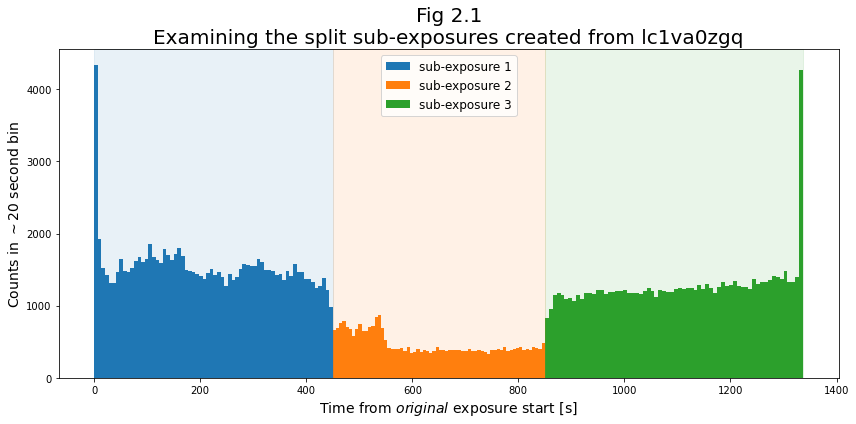

In [8]:
# Create the plot:
fig = plt.figure(figsize = (12, 6))

# Gather the split sub-exposure files:
spec_outlist = sorted(glob.glob('./output/spec_intervals/*fits'))
# Make histogram lightcurves as in previous plots
binsize = 20
for splitfile in spec_outlist:
    epoch_number = os.path.basename(splitfile).split('_')[1]
    ffs = Table.read(splitfile,1)
    timess = ffs['TIME']
    d,e,f = plt.hist(timess, bins = int(max(timesc)/binsize), alpha = 1, 
                    label = f"sub-exposure {epoch_number}")

# Add time ranges "epochs" or "windows of time" as transparent spans:
epoch_markers = [0,450,850, max(timesc)]
for i in range(3):
    plt.axvspan(epoch_markers[i], epoch_markers[i+1], 
                color = ['C0','C1','C2'][i], alpha = 0.1,
                label = None)    

# Format the Figure
plt.legend(fontsize = 12)
plt.title(f"Fig 2.1\nExamining the split sub-exposures created from {transit_basename}",
         size = 20)
plt.xlabel("Time from $original$ exposure start [s]", 
        fontsize = 14)
plt.ylabel(f"Counts in $\sim${binsize} second bin", 
        fontsize = 14)
plt.tight_layout()
plt.savefig(plots_dir + 'subexps.png', bbox_inches = 'tight', dpi = 200)


While not implemented within the Jupyter Notebook framework, you can also run `splittag` from a TEAL graphical user interface on a local computer (see FIG ???).

To generate the gui, open an astroconda python distribution (as described in the [Setup Notebook](), and run the following lines of python code:

```python
import costools
from stsci.tools import teal
teal.teal('splittag')
```

### Fig ???
<center><img src="./figures/TEAL_GUI.png" width ="900" title="TEAL GUI Interface"> </center>

Now that we have the three sub-exposure files, we can process them into 1-dimensional spectra using the [COS Calibration Pipeline: `CalCOS`](https://github.com/spacetelescope/calcos).

<a id=extractSp></a>
# 3. Extracting spectra from the sub-exposures using `CalCOS`

While for most circumstances, `CalCOS` is best run on an association file, (a fits table which specifies a series of exposures to calibrate and combine into a spectrum,) the `CalCOS` pipeline can be run on individual `rawtag` or `corrtag` files. 

* More information on running `CalCOS` can be found in [Chapter 3.6 of the COS Instrument Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration#id-3.6CustomizingCOSDataCalibration-3.6.1MechanicsofTailoredRecalibration)
* An interactive walkthrough to running the `CalCOS` can be found in [our notebook on the `CalCOS` pipeline](https://github.com/nkerman/notebooks/blob/main/notebooks/COS/CalCOS/CalCOS.ipynb).

To run `CalCOS`, your computer will need an `lref` system variable to tell the pipeline where to find your reference files. If you are on the STScI internet network (including via VPN), you may set this to the shared Institute lref directory. However, if you're not on the network, you will need to use the `CRDS` command to download the necessary reference files. This process is described in detail in Chapter 3 of our [notebook on setting up an environment for working with COS data](https://spacetelescope.github.io/COS-Notebooks/Setup.html#crdsS). 

Once you have downloded the files, you can set the environment variable to your CRDS cache using the code cell below.
The cell attempts to set your `lref` variable to the correct directory, but if you have created your own lref cache, you will need to replace the `<PATH TO YOUR CRDS REFERENCE FILE DIR>` string with the appropriate path.

In [9]:
if not os.environ.get('lref'):
    if os.path.exists('/grp/hst/cdbs/lref/'): # IF on STScI Network/VPN
        os.environ['lref'] = '/grp/hst/cdbs/lref/' 
        print("Looks like you're probably on the STScI network; setting lref to '/grp/hst/cdbs/lref/'")
    else: # IF NOT on STScI Network/VPN
        os.environ['lref'] = '<PATH TO YOUR CRDS REFERENCE FILE DIR>' #EDIT THIS PATH
        if not os.path.exists(os.environ['lref']): # check if that path exists
            print("Uh oh, I don't think that's a valid path. Deleting it.")
            del os.environ['lref'] # delete this nonexistant path
else:
    print(f"you already have an lref path, it's {os.environ.get('lref')}")

Looks like you're probably on the STScI network; setting lref to '/grp/hst/cdbs/lref/'


#### We can now run the pipeline on each of our new sub-exposure files to create processed spectra based on data taken in the three time periods.

Note that the cell below may take several minutes to complete.

In [10]:
for split_corrtag in spec_outlist: # When we run CalCOS on corrtags, we must go 1-by-1
    # epoch = which chunk of the initial exposure. epoch 2 contains the transit.
    epoch_number = os.path.basename(split_corrtag).split('_')[1] 
    print(f"Extracting file {split_corrtag} using CalCOS")
    # Make a sub-directory of output/calcos/ named for each epoch:
    cal_output_dir = f'./output/calcos/epoch{epoch_number}/'
    os.makedirs(cal_output_dir)
    # Extract the spectrum from each of the sub-exposures:
    calcos.calcos(split_corrtag, outdir = cal_output_dir, verbosity = 0)

Extracting file ./output/spec_intervals/lc1va0zgq_1_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.20.1
astropy version 4.2
Begin 10-May-2021 11:08:02 EDT
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR
    error estimate for y location = 5.93, FWHM = 5.45
Extracting file ./output/spec_intervals/lc1va0zgq_2_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.20.1
astropy version 4.2
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR
    error estimate for y location = 16.14, FWHM = 5.72
Extracting file ./output/spec_intervals/lc1va0zgq_3_corrtag_a.fits using CalCOS
CALCOS version 3.3.10
numpy version 1.20.1
astropy version 4.2
Shifting to 189, 0
Shifting to 189, 0
Extraction algorithm = BOXCAR
    error estimate for y location = 7.67, FWHM = 5.29


#### Now, we can take a look at our processed spectra
We first examine the entire spectrum:

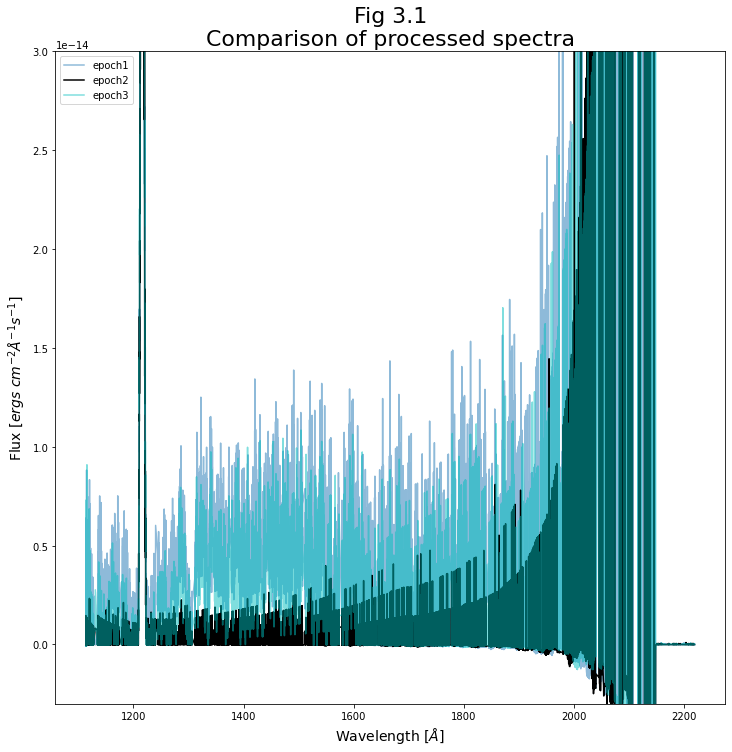

In [11]:
# Find all the `x1d` files:
processed_files = sorted(glob.glob('output/calcos/epoch*/*x1d.fits'))

# Set up figure
plt.figure(figsize = (12,12))

for i,pfile in enumerate(processed_files): # Loop through 
    epoch_label = pfile.split('/')[2]
    with warnings.catch_warnings(): 
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w,f,ferr,dq = Table.read(pfile)[0]['WAVELENGTH','FLUX','ERROR','DQ']
    dq_mask = np.where(dq == 0)
    w,f,ferr = w[dq_mask], f[dq_mask], ferr[dq_mask] # filter to good quality data
    plt.plot(w,f, # Plot each epoch
             alpha = [0.5,1,0.5][i], c= ['C0','k','c'][i], # Epoch2 should stand out
             label = epoch_label) # Label with the epoch name
# Format plot
plt.ylim(-3E-15,3E-14)
plt.title("Fig 3.1\nComparison of processed spectra", size = 22)
plt.xlabel("Wavelength [$\AA$]", size = 14)
plt.ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size = 14)
plt.legend()
plt.savefig(f"{plots_dir}Compare_spectrum.png", dpi = 200)

Now we can take a closer look at two spectral regions the region from 1200 - 1230 and from 1250 - 1300 Angstroms.
In the first region, we see the 1215 Angstrom Lyman-alpha line, which is [principally generated from geocoronal emission]()

This time, we will plot the errors as well, to see if the apparent differences in flux between epochs are significant.

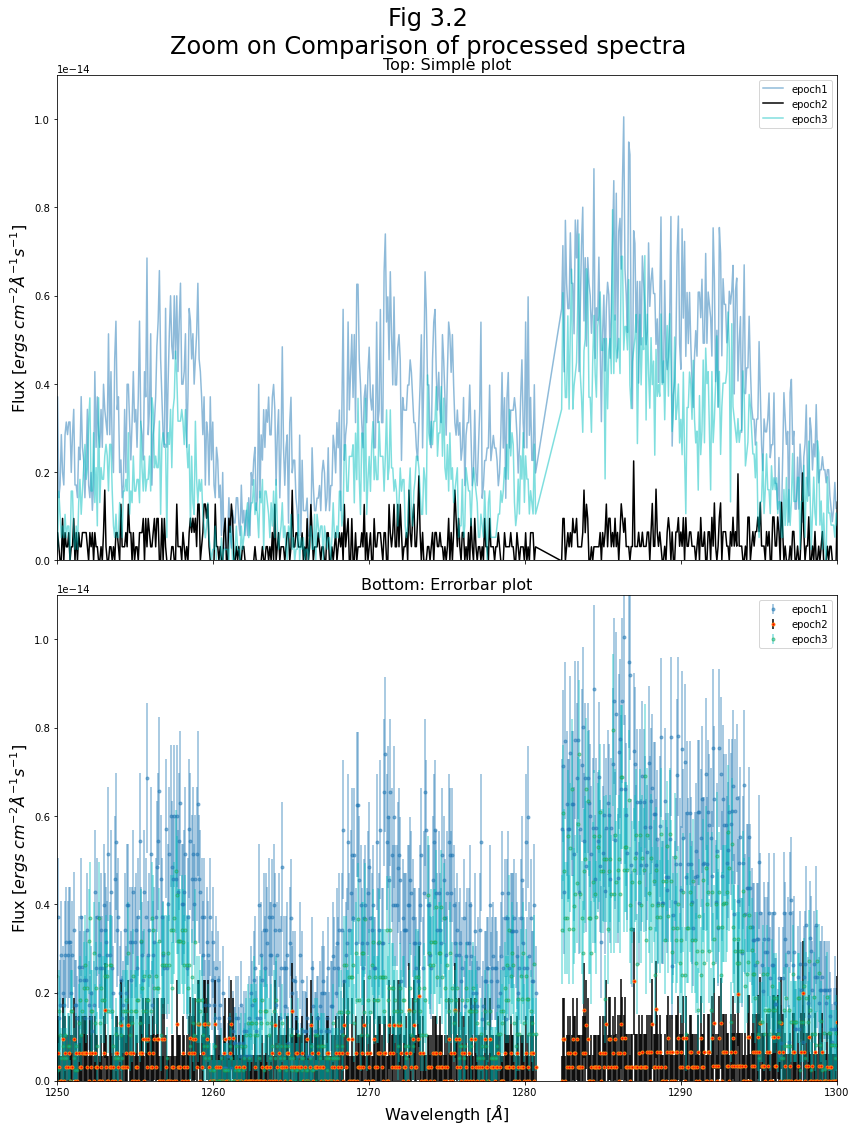

In [12]:
# Set up figure
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (12,16), sharex = True)

for i,pfile in enumerate(processed_files):
    epoch_label = pfile.split('/')[2]
    with warnings.catch_warnings(): 
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w,f,ferr,dq = Table.read(pfile)[0]['WAVELENGTH','FLUX','ERROR','DQ']
    dq_mask = np.where(dq == 0)
    w,f,ferr = w[dq_mask], f[dq_mask], ferr[dq_mask] # filter to good quality data

    ax0.plot(w,f, # Plot each epoch
             alpha = [0.5,1,0.5][i], # Epoch2 should stand out
             c = ['C0','k','c'][i], linestyle = '-',
             label = epoch_label) # Label with the epoch name

    ax1.errorbar(w,f,yerr=ferr, # Plot each epoch
             alpha = [0.5,1,0.5][i], # Epoch2 should stand out
             marker = '.',markerfacecolor = ['C0','r','c'][i],
             linestyle = '', ecolor =['C0','k','c'][i],
             label = epoch_label) # Label with the epoch name

    # Format both subplots
ax0.set_xlim(1250,1300) # Zoom to 1225 - 1300 Angstrom
ax1.set_xlim(1250,1300)
ax0.set_ylim(0,1.1E-14)
ax1.set_ylim(0,1.1E-14)

ax0.set_title("Top: Simple plot", fontsize = 16)
ax1.set_title("Bottom: Errorbar plot", fontsize = 16)
plt.suptitle("Fig 3.2\nZoom on Comparison of processed spectra", size = 24)
ax1.set_xlabel("Wavelength [$\AA$]", size = 16)
ax0.set_ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size = 16)
ax1.set_ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size = 16)
ax0.legend()
ax1.legend()
plt.tight_layout()
plt.savefig(f"{plots_dir}Compare_spectrum_zoom.png", dpi = 200)

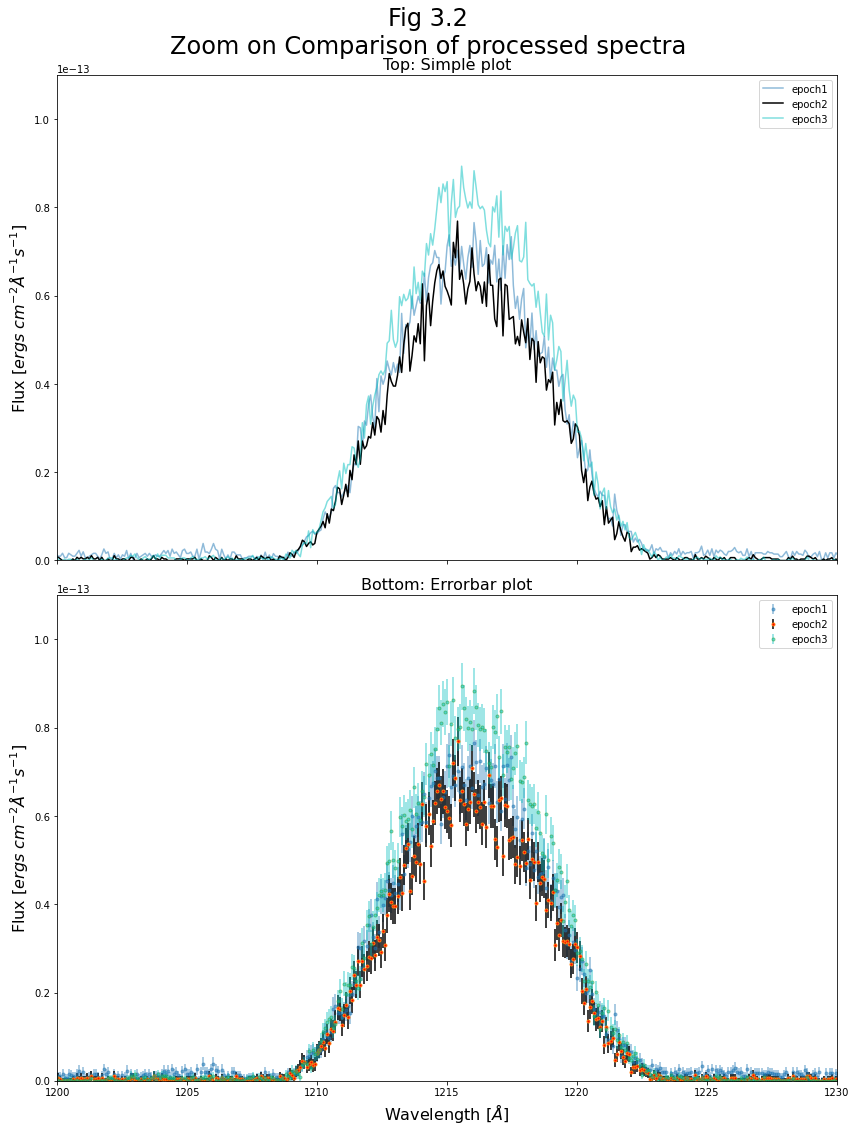

In [16]:
# Set up figure
fig, (ax0,ax1) = plt.subplots(2,1,figsize = (12,16), sharex = True)

for i,pfile in enumerate(processed_files):
    epoch_label = pfile.split('/')[2]
    with warnings.catch_warnings(): 
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w,f,ferr,dq = Table.read(pfile)[0]['WAVELENGTH','FLUX','ERROR','DQ']
    dq_mask = np.where(dq == 0)
    w,f,ferr = w[dq_mask], f[dq_mask], ferr[dq_mask] # filter to good quality data

    ax0.plot(w,f, # Plot each epoch
             alpha = [0.5,1,0.5][i], # Epoch2 should stand out
             c = ['C0','k','c'][i], linestyle = '-',
             label = epoch_label) # Label with the epoch name

    ax1.errorbar(w,f,yerr=ferr, # Plot each epoch
             alpha = [0.5,1,0.5][i], # Epoch2 should stand out
             marker = '.',markerfacecolor = ['C0','r','c'][i],
             linestyle = '', ecolor =['C0','k','c'][i],
             label = epoch_label) # Label with the epoch name

    # Format both subplots
ax0.set_xlim(1200,1230) # Zoom to 1225 - 1300 Angstrom
# ax1.set_xlim(1250,1300)
ax0.set_ylim(0,1.1E-13)
ax1.set_ylim(0,1.1E-13)

ax0.set_title("Top: Simple plot", fontsize = 16)
ax1.set_title("Bottom: Errorbar plot", fontsize = 16)
plt.suptitle("Fig 3.2\nZoom on Comparison of processed spectra", size = 24)
ax1.set_xlabel("Wavelength [$\AA$]", size = 16)
ax0.set_ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size = 16)
ax1.set_ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size = 16)
ax0.legend()
ax1.legend()
plt.tight_layout()
plt.savefig(f"{plots_dir}Compare_spectrum_zoom.png", dpi = 200)

Examining Fig 3.2, we see that while the very low number of counts in a given wavelength region has limited our spectra's precision, (especially evidenced by the quantized flux of epoch 2,) there still appears to be a significant change in the spectrum during the transit, with certain spectral features absent or suppressed during the transit.

This is certainly not an exhaustive analysis. However, you should now be equipped to use the `splittag` tool to 